In [1]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import pylab

from numba import njit, prange

In [2]:
dt = .001
tau = .1
noise_tau = .002
w11, w22 = 1, 1
w21, w12 = 1, 1
dur = 2
bifurcate_time = .8
sgm = 1
threshold = 70
S = 250
R_initial = 32
eta = S*.04

In [3]:
@njit(parallel=True, fastmath=True)
def get_dynamic_arr(coh, a, b_initial, b_later):

    alpha = a

    active_correct_trials = np.zeros(int(dur/dt))
    active_correct_trials[0] = 10240

    RT_arr = np.zeros(int(dur/dt))
    RT_arr[0] = 0

    if coh > 0:
        saccade_in = True
        saccade_out = False
    else:
        saccade_in = False
        saccade_out = True

    for i in prange(10240):

        beta = b_initial
        V1, V2 = S, S
        correct = False
        trials_count = np.zeros(int(dur/dt))

        R1_arr = np.zeros(int(dur/dt))
        R2_arr = np.zeros(int(dur/dt))
        R1_arr[0] = ((alpha-1) + np.sqrt((1-alpha)**2 + 4*S*(w11+w12-beta))) / (2*(w11+w12-beta))
        R2_arr[0] = ((alpha-1) + np.sqrt((1-alpha)**2 + 4*S*(w22+w21-beta))) / (2*(w22+w21-beta))

        G1_arr = np.zeros(int(dur/dt))
        G2_arr = np.zeros(int(dur/dt))
        G1_arr[0], G2_arr[0] = (w11+w12-beta)*R1_arr[0], (w22+w21-beta)*R2_arr[0]

        D1_arr = np.zeros(int(dur/dt))
        D2_arr = np.zeros(int(dur/dt))
        D1_arr[0], D2_arr[0] = beta*R1_arr[0], beta*R2_arr[0]

        noise_R1 = np.zeros(int(dur/dt))
        noise_R2 = np.zeros(int(dur/dt))
        noise_G1 = np.zeros(int(dur/dt))
        noise_G2 = np.zeros(int(dur/dt))
        noise_D1 = np.zeros(int(dur/dt))
        noise_D2 = np.zeros(int(dur/dt))

        for ti in range(1, int(dur/dt)):

            if ti == bifurcate_time/dt:
                    beta = b_later
                    V1 = S*(1+coh)
                    V2 = S*(1-coh)

            if ti >= bifurcate_time/dt and ti % 5 == 0:
                    V1 = S*(1+coh) + np.random.randn() * eta
                    V2 = S*(1-coh) + np.random.randn() * eta

            d_noiseR1 = (-noise_R1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseR2 = (-noise_R2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseG1 = (-noise_G1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseG2 = (-noise_G2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseD1 = (-noise_D1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseD2 = (-noise_D2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt

            d_R1 = (-R1_arr[ti-1] + (alpha * R1_arr[ti-1] + V1) / (1 + G1_arr[ti-1])) * dt/tau
            d_R2 = (-R2_arr[ti-1] + (alpha * R2_arr[ti-1] + V2) / (1 + G2_arr[ti-1])) * dt/tau
            d_G1 = (-G1_arr[ti-1] + w11*R1_arr[ti-1] + w12*R2_arr[ti-1] - D1_arr[ti-1]) * dt/tau
            d_G2 = (-G2_arr[ti-1] + w21*R1_arr[ti-1] + w22*R2_arr[ti-1] - D2_arr[ti-1]) * dt/tau
            d_D1 = (-D1_arr[ti-1] + beta*R1_arr[ti-1]) *dt/tau
            d_D2 = (-D2_arr[ti-1] + beta*R2_arr[ti-1]) *dt/tau

            noise_R1[ti] = noise_R1[ti-1] + d_noiseR1
            noise_R2[ti] = noise_R2[ti-1] + d_noiseR2
            noise_G1[ti] = noise_G1[ti-1] + d_noiseG1
            noise_G2[ti] = noise_G2[ti-1] + d_noiseG2
            noise_D1[ti] = noise_D1[ti-1] + d_noiseD1
            noise_D2[ti] = noise_D2[ti-1] + d_noiseD2

            R1_arr[ti] = max(R1_arr[ti-1] + d_R1 + noise_R1[ti], 0)
            R2_arr[ti] = max(R2_arr[ti-1] + d_R2 + noise_R2[ti], 0)
            G1_arr[ti] = max(G1_arr[ti-1] + d_G1 + noise_G1[ti], 0)
            G2_arr[ti] = max(G2_arr[ti-1] + d_G2 + noise_G2[ti], 0)
            D1_arr[ti] = max(D1_arr[ti-1] + d_D1 + noise_D1[ti], 0)
            D2_arr[ti] = max(D2_arr[ti-1] + d_D2 + noise_D2[ti], 0)

            trials_count[ti] = 1

            if R1_arr[ti] > threshold and ti >= bifurcate_time/dt:
                if saccade_in:
                    correct = True
                break

            elif R2_arr[ti] > threshold and ti >= bifurcate_time/dt:
                if saccade_out:
                    correct = True
                break

        if correct:
            RT_arr += R1_arr
            active_correct_trials += trials_count

    # stop = 0
    # for sec, trial_num in enumerate(active_correct_trials):
    #     if trial_num < 10240/2:
    #         stop = sec

    return np.divide(RT_arr, active_correct_trials)[500:1400]

In [70]:
def same_baseline_dynamic(coh, a, b_initial, accuracy_b, neutral_b, speed_b, ax):
    in_accuracy_dynamic = get_dynamic_arr(coh, a, b_initial, accuracy_b)
    out_accuracy_dynamic = get_dynamic_arr(-coh, a, b_initial, accuracy_b)
    in_neutral_dynamic = get_dynamic_arr(coh, a, b_initial, neutral_b)
    out_neutral_dynamic = get_dynamic_arr(-coh, a, b_initial, neutral_b)
    in_speed_dynamic = get_dynamic_arr(coh, a, b_initial, speed_b)
    out_speed_dynamic = get_dynamic_arr(-coh, a, b_initial, speed_b)

    ax.plot(in_accuracy_dynamic, label="Accuracy (α=%d, original β=0, new β=%.1f)" % (a, accuracy_b), color='red')
    ax.plot(out_accuracy_dynamic,  color='red', linestyle='dashed')
    ax.plot(in_neutral_dynamic, label="Neutral (α=%d, original β=0, new β=%.1f)" % (a, neutral_b), color='black')
    ax.plot(out_neutral_dynamic, color='black', linestyle='dashed')
    ax.plot(in_speed_dynamic, label="Speed (α=%d, original β=0, new β=%.1f)" % (a, speed_b), color='green')
    ax.plot(out_speed_dynamic, color='green', linestyle='dashed')

    ax.set_title("Same Baseline")
    ax.set_xlabel("Time from Array (ms)")
    ax.set_ylabel("Firing Rate (Hz)")
    ax.legend(bbox_to_anchor=(1.15, 1.3))

    ax.xaxis.set_ticks(np.arange(0, int(ax.get_xlim()[1]), 100))
    ax.xaxis.set_ticklabels(np.arange(-300, int(ax.get_xlim()[1]-300), 100))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.spines.bottom.set_position(('data', 10))
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.annotate('Input', (920, 3), color='black', fontsize=14)
    ax.hlines(y=4, xmin=0, xmax=300, color='mediumpurple', linestyle='dashed', linewidth=1.5)
    ax.hlines(y=4, xmin=300, xmax=900, color='rebeccapurple', linewidth=1.5)

    ax.annotate('Disinhibition', (920, -.5), color='black', fontsize=14)
    ax.hlines(y=-1, xmin=0, xmax=300, color='lightcoral', linewidth=1.5)
    ax.vlines(x=300, ymin=-1, ymax=1, color='indianred', linewidth=1.5)
    ax.hlines(y=1, xmin=300, xmax=900, color='brown', linewidth=1.5)

    ax.xaxis.set_label_coords(.5, -.005)

In [69]:
def diff_baseline_dynamic(coh, a, accuracy_b_ini, neutral_b_ini, speed_b_ini, accuracy_b, neutral_b, speed_b, ax):
    in_accuracy_dynamic = get_dynamic_arr(coh, a, accuracy_b_ini, accuracy_b)
    out_accuracy_dynamic = get_dynamic_arr(-coh, a, accuracy_b_ini, accuracy_b)
    in_neutral_dynamic = get_dynamic_arr(coh, a, neutral_b_ini, neutral_b)
    out_neutral_dynamic = get_dynamic_arr(-coh, a, neutral_b_ini, neutral_b)
    in_speed_dynamic = get_dynamic_arr(coh, a, speed_b_ini, speed_b)
    out_speed_dynamic = get_dynamic_arr(-coh, a, speed_b_ini, speed_b)

    ax.plot(in_accuracy_dynamic, label="Accuracy (α=%d, original β=%.1f, new β=%.1f)" % (a, accuracy_b_ini, accuracy_b), color='red')
    ax.plot(out_accuracy_dynamic,  color='red', linestyle='dashed')
    ax.plot(in_neutral_dynamic, label="Neutral (α=%d, original β=%.1f, new β=%.1f)" % (a, neutral_b_ini, neutral_b), color='black')
    ax.plot(out_neutral_dynamic, color='black', linestyle='dashed')
    ax.plot(in_speed_dynamic, label="Speed (α=%d, original β=%.1f, new β=%.1f)" % (a, speed_b_ini, speed_b), color='green')
    ax.plot(out_speed_dynamic, color='green', linestyle='dashed')

    ax.set_title("Different Baselines")
    ax.set_xlabel("Time from Array (ms)")
    ax.set_ylabel("Firing Rate (Hz)")
    ax.legend(bbox_to_anchor=(1.15, 1.3))

    ax.xaxis.set_ticks(np.arange(0, int(ax.get_xlim()[1]), 100))
    ax.xaxis.set_ticklabels(np.arange(-300, int(ax.get_xlim()[1]-300), 100))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.spines.bottom.set_position(('data', 10))
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.annotate('Input', (920, 3), color='black', fontsize=14)
    ax.hlines(y=4, xmin=0, xmax=300, color='mediumpurple', linestyle='dashed', linewidth=1.5)
    ax.hlines(y=4, xmin=300, xmax=900, color='rebeccapurple', linewidth=1.5)

    ax.annotate('Disinhibition', (920, -.5), color='black', fontsize=14)
    ax.hlines(y=0, xmin=0, xmax=300, color='lightcoral', linewidth=1.5)
    ax.vlines(x=300, ymin=0, ymax=1, color='indianred', linewidth=1.5)
    ax.hlines(y=1, xmin=300, xmax=900, color='brown', linewidth=1.5)

    ax.xaxis.set_label_coords(.5, -.005)

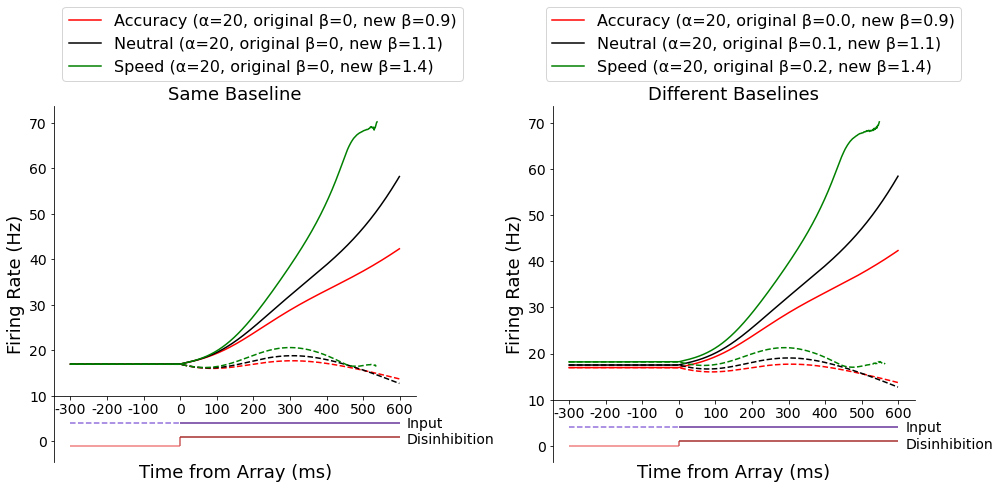

In [72]:
fig2, (same_b_ax2, diff_b_ax2) = plt.subplots(1, 2, figsize=(14, 7), sharex=True)
same_baseline_dynamic(.256, 20, 0, .9, 1.1, 1.4, same_b_ax2)
diff_baseline_dynamic(.256, 20, 0, .1, .2, .9, 1.1, 1.4, diff_b_ax2)
plt.tight_layout()

font_size = 18
params = {
    'legend.fontsize': 16,
     'axes.labelsize': font_size,
     'axes.titlesize': font_size,
     'xtick.labelsize': 14,
     'ytick.labelsize': 14
}
pylab.rcParams.update(params)

plt.savefig('Baselines.tiff', format='tiff')